<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.get('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

In [2]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from IPython.display import HTML

# Initial Conditions

These are the initial conditions for the two pendulum.

In [3]:
pi=np.pi

#Initial Conditions. Starts at origin with no velocity. x1 corresponds to z and x2 corresponds to dz/dx initial
m = 10.0
g = 9.81
l = 1.0
R = 6371000

theta1init=pi/2
theta2init=0
p1init=-10
p2init= 10


This is the time spacing when solving the system of ODEs. It specifies the total time we wish to solve the system for and the spacing between times.

In [4]:
fps = 60
ttotal=60
dt=1./(fps)
t = np.arange(0.0, ttotal, dt)

# Functions Used

## Solving the ODE's

The system of equations for the double pendulum are as follows:

$$\frac{d\theta_1}{dt} =\frac{1}{ml^2}\frac{p_1-p_2\cos(\theta_1-\theta_2)}{(1+\sin(\theta_1-\theta_2)^2)} $$

$$\frac{d\theta_2}{dt} =\frac{1}{ml^2}\frac{2p_2-p_1\cos(\theta_1-\theta_2)}{(1+\sin(\theta_1-\theta_2)^2)} $$

$$\frac{dp_1}{dt} =-\frac{1}{ml^2}\frac{(1+\sin^2(\theta_1-\theta_2))(2p_1p_2\sin(\theta_1-\theta_2))-(p_1^2+2p_2^2-2p_1p_2\cos(\theta_1-\theta_2))(2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2))}{2(1+\sin^2(\theta_1-\theta_2))}-2mgl\sin(\theta_1)$$

$$\frac{dp_2}{dt} =-\frac{1}{ml^2}\frac{(1+\sin^2(\theta_1-\theta_2))(-2p_1p_2\sin(\theta_1-\theta_2))+(p_1^2+2p_2^2-2p_1p_2\cos(\theta_1-\theta_2))(2\sin(\theta_1-\theta_2)\cos(\theta_1-\theta_2))}{2(1+\sin^2(\theta_1-\theta_2))}-mgl\sin(\theta_2)$$

In [5]:
def odesystem(x1,x2,x3,x4):
    deriv1=(x3-x4*math.cos(x1-x2))/(m*(l**2)*(1+(math.sin(x1-x2))**2))

    deriv2=(2*x4-x3*math.cos(x1-x2))/(m*(l**2)*(1+(math.sin(x1-x2))**2))

    deriv3=-((1+(math.sin(x1-x2))**2)*(2*x3*x4*math.sin(x1-x2))-(x3**2+2*x4**2-2*x3*x4*math.cos(x1-x2))*(2*math.sin(x1-x2)*math.cos(x1-x2)))/(2*m*(l**2)*(1+(math.sin(x1-x2))**2)**2)-2*m*g*l*math.sin(x1)

    deriv4=-((1+(math.sin(x1-x2))**2)*(-2*x3*x4*math.sin(x1-x2))+(x3**2+2*x4**2-2*x3*x4*math.cos(x1-x2))*(2*math.sin(x1-x2)*math.cos(x1-x2)))/(2*m*(l**2)*(1+(math.sin(x1-x2))**2)**2)-m*g*l*math.sin(x2)

    derivarray=[deriv1,deriv2,deriv3,deriv4]
    return derivarray
    
#w is an n by 2 array where n is the number of data points used and 2 is the number of variables in the coupled ODE's
def vectorfield(w, t):
    x1, x2, x3, x4 = w
    f = odesystem(x1,x2,x3,x4)   #f=[x1', x2', x3', x4'] corresponds to the vector field that takes in the input data and returns a slope field
    return f

w0=[theta1init,theta2init,p1init,p2init]
w1=[theta1init,theta2init+0.05,p1init,p2init]

wsol1 = odeint(vectorfield, w0, t)
g = g*(R/(R+0.1))**2
wsol2 = odeint(vectorfield, w0, t)

## Used for Animation

Initializes the axis by drawing 2 blank lines. This is passed into the animation function.

In [6]:
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return lines

Gives the coodiantes of where the dots for the pendulum masses should be drawn at the ith frame. ox and oy are used as offset for the hinge of the pendulum. We include this functionality to allow us to draw multiple pendulums on the same plot.

In [7]:
def placement(wsol,ox,oy,i):
    thisx = [ox,ox+l*math.sin(wsol[i,0]), ox+l*math.sin(wsol[i,0])+l*math.sin(wsol[i,1])]
    thisy = [oy,oy-l*math.cos(wsol[i,0]), oy-l*math.cos(wsol[i,0])-l*math.cos(wsol[i,1])]
    return thisx, thisy

This animate function takes in the coordiantes from the function above and applies it to the lines drawn on the axis.

In [8]:
def animate(i):
    line1.set_data(placement(wsol1,2*l,2*l,i))
    line2.set_data(placement(wsol2,-2*l,2*l,i))
    time_text.set_text(time_template % (i*dt))
    return tuple(lines) + (time_text,)

# Plotting Animation

Create the figure and axis we wish to use for the animation. Add the two lines to the plot which will be used for drawing the pendulum.

In [9]:
%%capture

fig = plt.figure()
ax = plt.axes(xlim=(-4*l,4*l), ylim=(-4*l, 4*l))
line1, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], 'o-', lw=2)
lines= [line1,line2]

#Displays time in the top corner
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

By setting the interval equal to 1/fps = dt in the array of times, the frame rate matches up with the actual time. (We draw a new frame - aka next value of $\theta_1$, etc - aka occured after time dt, every dt seconds). We multiply by 1000 because by default we are in milliseconds. The total time is 25 seconds.

In [18]:
frames = 60*fps
interval = 1000*(1./fps) #milliseconds

anim = animation.FuncAnimation(fig, animate, frames = frames, init_func=init, interval=interval, blit=True)

In [19]:
HTML(anim.to_html5_video())

# Additional Phase Space Plots

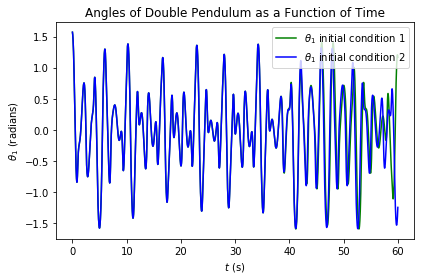

In [12]:
#Plots a Figure of the First ODE solution
plt.figure(1)
plotcur=plt.plot(t, wsol1[:,0], '-g', label=r"$\theta_1$ initial condition 1")
plt.plot(t, wsol2[:,0], '-b',label=r"$\theta_1$ initial condition 2")
plt.xlabel(r"$t$ (s)")
plt.ylabel(r"$\theta_1$ (radians)")
plt.legend(loc='upper right')
plt.title("Angles of Double Pendulum as a Function of Time")
plt.tight_layout()
plt.show()

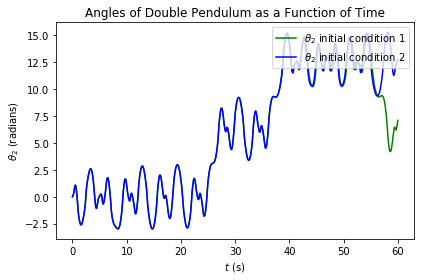

In [13]:
plt.figure(2)
plotcur=plt.plot(t, wsol1[:,1], '-g', label=r"$\theta_2$ initial condition 1")
plt.plot(t, wsol2[:,1], '-b',label=r"$\theta_2$ initial condition 2")
plt.xlabel(r"$t$ (s)")
plt.ylabel(r"$\theta_2$ (radians)")
plt.legend(loc='upper right')
plt.title("Angles of Double Pendulum as a Function of Time")
plt.tight_layout()

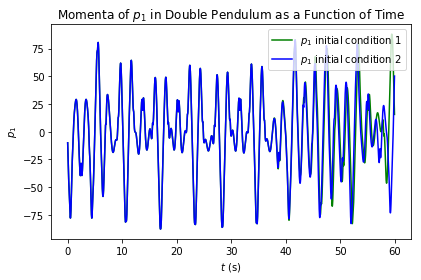

In [14]:
plt.figure(3)
plotcur=plt.plot(t, wsol1[:,2], '-g', label=r"$p_1$ initial condition 1")
plt.plot(t, wsol2[:,2], '-b',label=r"$p_1$ initial condition 2")
plt.xlabel(r"$t$ (s)")
plt.ylabel(r"$p_1$")
plt.legend(loc='upper right')
plt.title(r"Momenta of $p_1$ in Double Pendulum as a Function of Time")
plt.tight_layout()

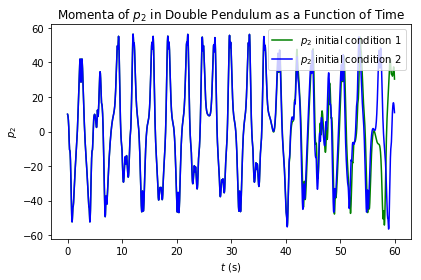

In [15]:
plt.figure(4)
plotcur=plt.plot(t, wsol1[:,3], '-g', label=r"$p_2$ initial condition 1")
plt.plot(t, wsol2[:,3], '-b',label=r"$p_2$ initial condition 2")
plt.xlabel(r"$t$ (s)")
plt.ylabel(r"$p_2$")
plt.legend(loc='upper right')
plt.title(r"Momenta of $p_2$ in Double Pendulum as a Function of Time")
plt.tight_layout()

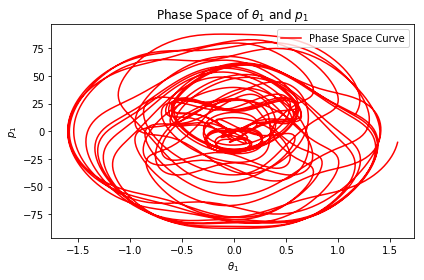

In [16]:
plt.figure(5)
plotcur=plt.plot(wsol1[:,0], wsol1[:,2], '-r', label=r"Phase Space Curve")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$p_1$")
plt.legend(loc='upper right')
plt.title(r"Phase Space of $\theta_1$ and $p_1$")
plt.tight_layout()

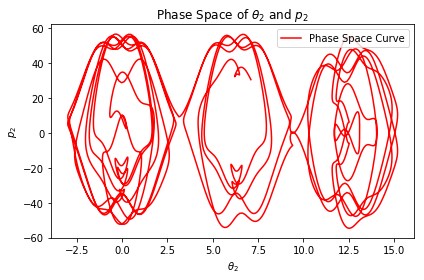

In [17]:
plt.figure(6)
plotcur=plt.plot(wsol1[:,1], wsol1[:,3], '-r', label=r"Phase Space Curve")
plt.xlabel(r"$\theta_2$")
plt.ylabel(r"$p_2$")
plt.legend(loc='upper right')
plt.title(r"Phase Space of $\theta_2$ and $p_2$")
plt.tight_layout()